# Классификация мошеннических транзакций с использованием методов машинного обучения

## Подготовка к заданию:

- Скачать набор данных creditcard.csv с https://www.kaggle.com/mlg-ulb/creditcardfraud, в котором: Time – время транзакции, V1-V28 – признаки, Amount – количество, Class – класс транзакции: мошенническая (Class=1) и легальная (Class=0).

- Использовать из набора данных только первые 50 000 записей.

- Используя train_test_split(…, test_size=0.3, stratify=df.Class) разбить выборку (c_card.csv) на тренировочное и тестовое множества так, чтобы тестовая выборка составляла 30% от всей выборки и в тестовой выборке пропорция мошеннических и легальных транзакций была такой же как и в основной выборке (stratify).

- При решении задачи классификации транзакций на мошеннические и легальные необходимо максимизировать метрику macro f1 на тестовой выборке.

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
import lightgbm as lgb
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import preprocessing

import graphviz
from sklearn import tree

### Загрузка данных

In [12]:
df = pd.read_csv('creditcard.csv', nrows=50000)  # Используем только первые 50,000 записей
x = df.drop(columns='Class')  # Признаки
y = df['Class']  # Целевая переменная

In [13]:
# Разбиение на тренировочную и тестовую выборки (30% тестовая, стратификация по классу)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, stratify=df.Class)

Масштабирование данных StandardScaler()

In [14]:
# Масштабирование данных (стандартизация)
scaler = preprocessing.StandardScaler().fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [15]:
# Функция для подсчета метрик и построения матрицы ошибок
def get_metrics_plot_confusion_matrix(clf, x_test, y_test, y_pred):
    print(classification_report(y_test, y_pred))  # Вывод метрик: precision, recall, f1-score
    
    cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
    disp.plot()
    plt.show()

### **Матрица ошибок** (матрица неточностей, [confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html))
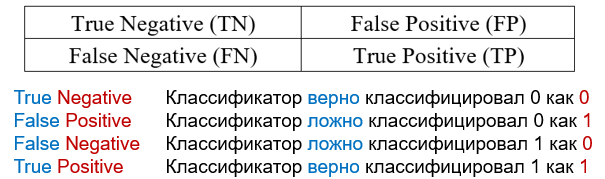

True Negative == предсказан 0 (Negative), и предсказан верно (True)


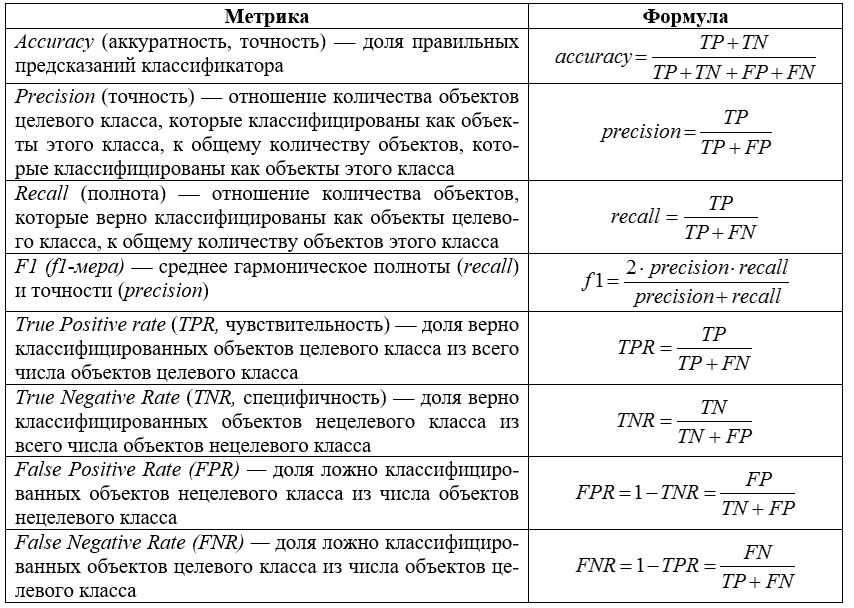

## Задание 1 (Сравнение методов)

Сравнить значения метрики macro_f1 при тестировании методов: 
- дерево принятия решений, 
- бэггинга деревьев решений,
- случайного леса.

### Дерево принятия решений (Decision Tree)

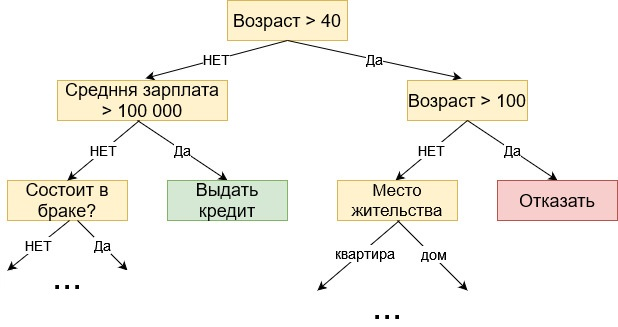

Начав с корня (через которых прохожят все обучающие примеры)), создавются новые узлы, постепенно разделяя набор обучающих примеров на меньшие части по атрибутам и порогам до тех пор, пока не останется в каждом узле по одному примеру. Также возможно выполнение других заданных критерии остановки обучения.

Decision Tree Classifier
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14956
           1       0.86      0.86      0.86        44

    accuracy                           1.00     15000
   macro avg       0.93      0.93      0.93     15000
weighted avg       1.00      1.00      1.00     15000



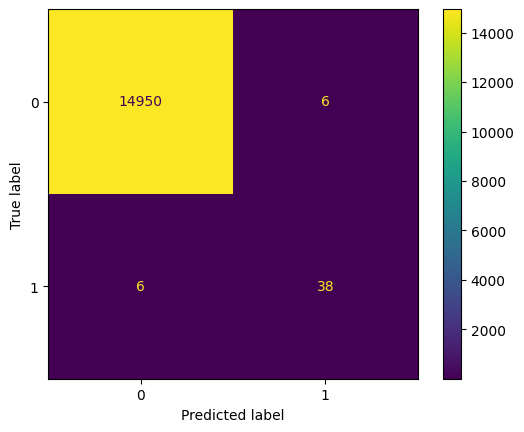

In [16]:
clf_tree = DecisionTreeClassifier(max_depth=4)
clf_tree.fit(x_train, y_train)
y_pred_tree = clf_tree.predict(x_test)
print("Decision Tree Classifier")
get_metrics_plot_confusion_matrix(clf_tree, x_test, y_test, y_pred_tree)

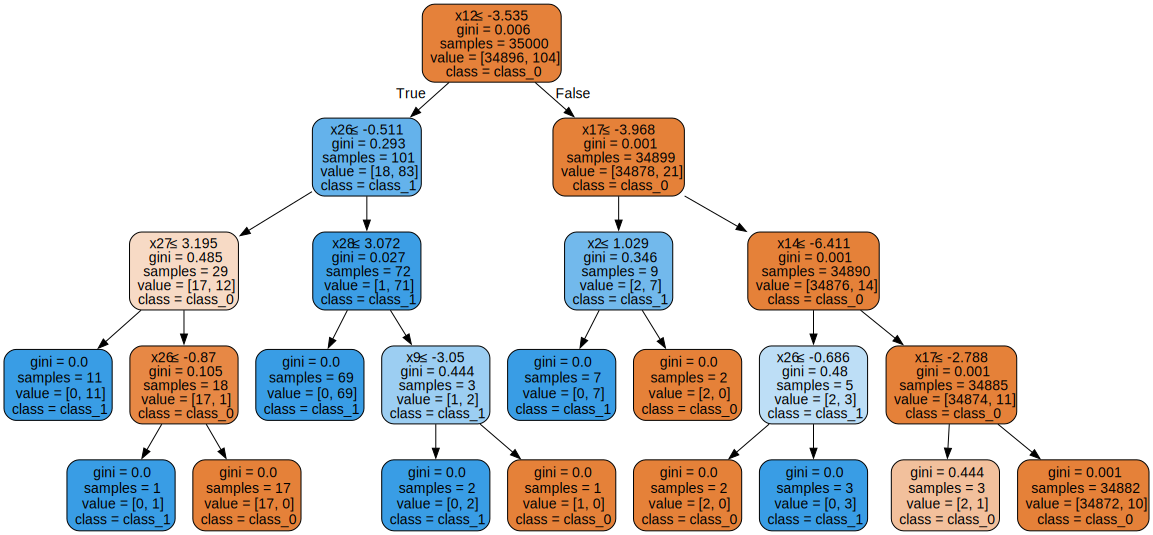

In [17]:
new_graph = tree.export_graphviz(clf_tree,
                     out_file=None,  # Можно указать файл для сохранения изображения
                     class_names=['class_0', 'class_1'],   # Названия классов
                     filled=True, rounded=True, special_characters=True) # Детали отображения

graph = graphviz.Source(new_graph)  # Создаем представление graphviz
graph  # Вывод на экран

### Бэггинг деревьев решений (Bagging)

**"Беггинг"** (Bagging, сокращение от  Bootstrap Aggregation) - модели одного типа обучаются независимо, результаты их объединяются путем голосования и выбора по большинству голосов для классификации или усреднением для регрессии. Чтобы не обучились одинаковые модели, используют подмножества данных, случайно выбранные из общего набора, выбор происходит равномерно с повторениями (bootstrap), поэтому каждый пример данных отбирается равновероятно и может оказаться в нескольких таких подмножествах.

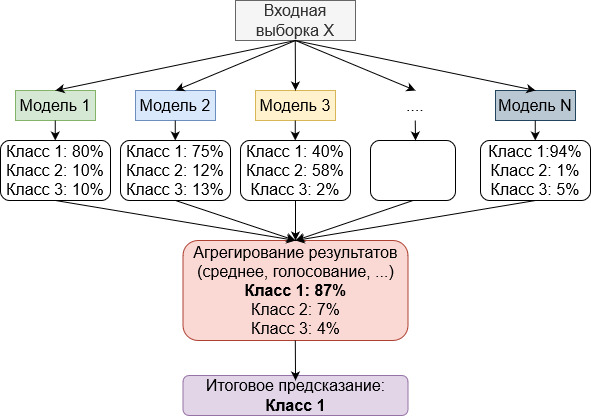

Bagging Classifier
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14956
           1       0.87      0.93      0.90        44

    accuracy                           1.00     15000
   macro avg       0.94      0.97      0.95     15000
weighted avg       1.00      1.00      1.00     15000



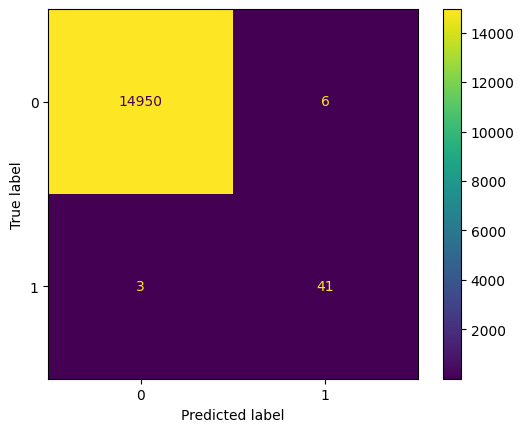

In [18]:
clf_bagging = BaggingClassifier(DecisionTreeClassifier(), n_estimators=10, max_samples=0.5)
clf_bagging.fit(x_train, y_train)
y_pred_bagging = clf_bagging.predict(x_test)
print("Bagging Classifier")
get_metrics_plot_confusion_matrix(clf_bagging, x_test, y_test, y_pred_bagging)

### Случайный лес (Random Forest)

Как можно улучшить работу (увеличить метрики работы) дерева принятия решения?

1. **Создавать более глубокое дерево**. Тогда его слишком долго "обсчитывать" и теряется обобщающая способность.
2. **Создать много неглубоких деревьев** и применить голосование "по большинству". Если 90% деревьев выбрали один и тот же класс, то можно поверить "большинству"

Много случайно созданных деревьев образуют **случайный лес**.


Средняя точность = 0.9996
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14956
           1       0.95      0.91      0.93        44

    accuracy                           1.00     15000
   macro avg       0.98      0.95      0.97     15000
weighted avg       1.00      1.00      1.00     15000



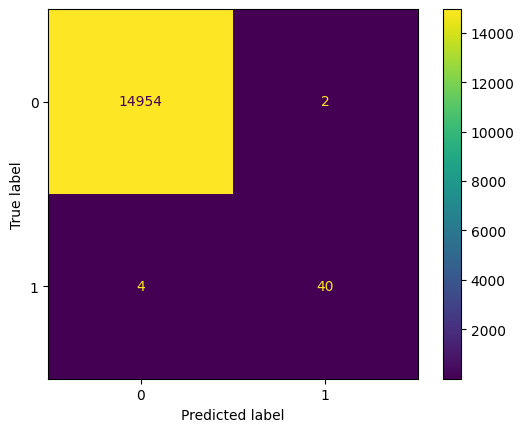

In [19]:
# Классификатор на основе случайного леса
from sklearn.ensemble import RandomForestClassifier # Cлучайный лес
clf_rf = RandomForestClassifier(n_estimators=150,
                             max_depth=10,
                             max_features=2)
clf_rf.fit(x_train, y_train) # Обучение
y_pred_rf = clf_rf.predict(x_test) # Тестирование
score=clf_rf.score(x_test, y_test) # Средняя точность
print('Средняя точность =', score)
get_metrics_plot_confusion_matrix(clf_rf, x_test, y_test, y_pred_rf)

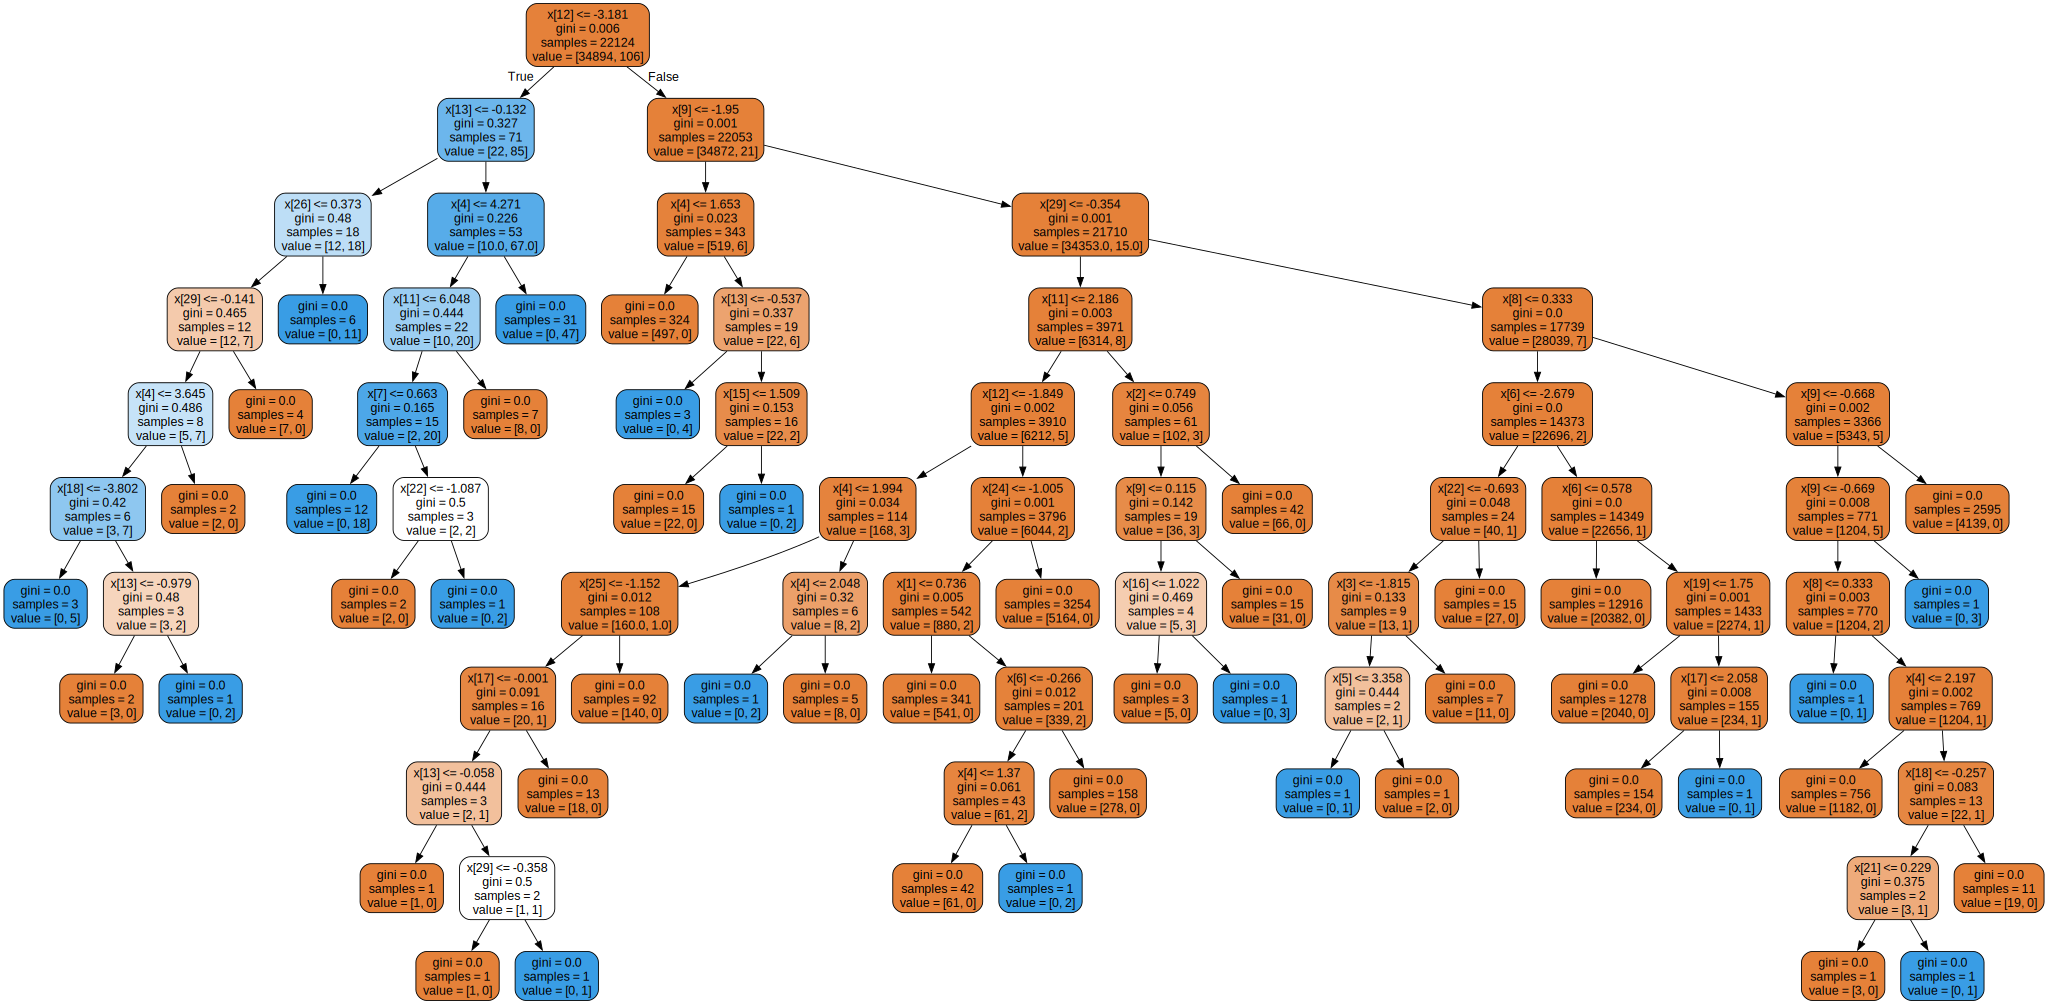

In [20]:
tree_data=clf_rf.estimators_[2] # третье дерево

gr_data = tree.export_graphviz(tree_data, out_file=None, filled=True, rounded=True)
graph = graphviz.Source(gr_data)
graph  # отображаем на экране


## Задание 2 (Оптимизация случайного леса)

- Оптимизировать/настроить параметры (GridSearchCV) случайного леса для максимизации значения f1_macro (scoring='f1_macro') на тестовой выборке. 
- Для метода, обеспечившего максимум f1_macro, построить матрицу ошибок.

In [21]:
# Оптимизация случайного леса с помощью GridSearchCV
rfc = RandomForestClassifier(bootstrap=False, random_state=42, n_jobs=-1, criterion='entropy')

In [22]:
rfc = RandomForestClassifier(bootstrap=False, random_state=42, n_jobs=-1, criterion='entropy')

# Задаем словарь для перебора значений парамтеров
params = {'n_estimators': [10, 50, 100], 'max_depth': [5, 10, 20]}

clf_grid = GridSearchCV(rfc, params, scoring='f1_macro', verbose=50, n_jobs=-1)
clf_grid.fit(x_train, y_train)

best_clf = clf_grid.best_estimator_
print(f"Best Random Forest from GridSearchCV: {best_clf}")

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best Random Forest from GridSearchCV: RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=10,
                       n_estimators=50, n_jobs=-1, random_state=42)


Best Random Forest (after GridSearchCV)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14956
           1       0.91      0.91      0.91        44

    accuracy                           1.00     15000
   macro avg       0.95      0.95      0.95     15000
weighted avg       1.00      1.00      1.00     15000



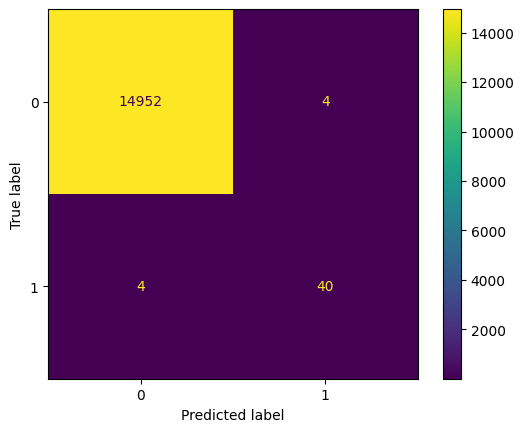

In [23]:
# Прогнозирование с лучшей моделью и оценка
y_pred_best_rf = best_clf.predict(x_test)
print("Best Random Forest (after GridSearchCV)")
get_metrics_plot_confusion_matrix(best_clf, x_test, y_test, y_pred_best_rf)

## Задание 3 (Применение ансамблей моделей)

Примененеие ансамблей моделей. Обучить и для обученных моделей получить (вывести на экран) матрицу метрик и матрицу ошибок на тестовой выборке, сравнить значение метрии f1_macro. Модели:

а) LightGBM-классификтор,\
б) стекинг с не менее тремя моделями ML:

    1-я модель) Случайный лес с полученными в задаче 2 значениями,
    2-я модель) xgboost,
    3-я модель) выбрать самостоятельно.

### LightGBM

библиотека с эффективной реализацией алгоритма градиентного бустинга.
Применим в задачах регрессии и классификации.

d:\_petrsu\data_analysis_in_python\007_classification_tabular_data\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 104, number of negative: 34896
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003719 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 35000, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002971 -> initscore=-5.815737
[LightGBM] [Info] Start training from score -5.815737


d:\_petrsu\data_analysis_in_python\007_classification_tabular_data\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LightGBM Classifier
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     14956
           1       0.21      0.50      0.30        44

    accuracy                           0.99     15000
   macro avg       0.61      0.75      0.65     15000
weighted avg       1.00      0.99      0.99     15000



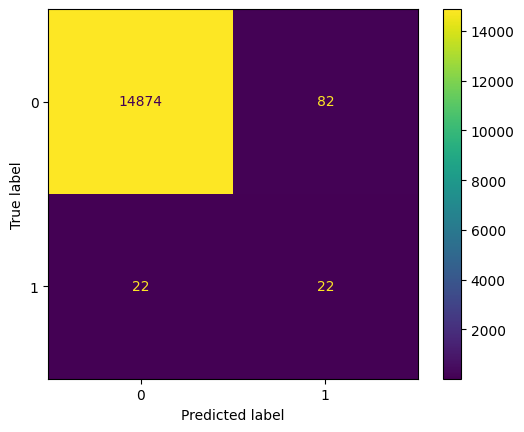

In [24]:
clf_lgb = lgb.LGBMClassifier(objective="binary", n_estimators=100)
clf_lgb.fit(x_train, y_train)
y_pred_lgb = clf_lgb.predict(x_test)
print("LightGBM Classifier")
get_metrics_plot_confusion_matrix(clf_lgb, x_test, y_test, y_pred_lgb)

### Стекинг (Stacking) с несколькими моделями

In [25]:
estimators = [
    ('RandomForest', RandomForestClassifier(n_estimators=50, max_depth=5, max_features=2)),
    ('GradientBoosting', GradientBoostingClassifier(n_estimators=50, max_depth=5)),
    ('DecisionTree', DecisionTreeClassifier(max_depth=3))
]

In [26]:
from sklearn.linear_model import LogisticRegression

In [27]:
clf_stacking = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
clf_stacking.fit(x_train, y_train)
y_pred_stacking = clf_stacking.predict(x_test)

Stacking Classifier
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14956
           1       0.86      0.84      0.85        44

    accuracy                           1.00     15000
   macro avg       0.93      0.92      0.93     15000
weighted avg       1.00      1.00      1.00     15000



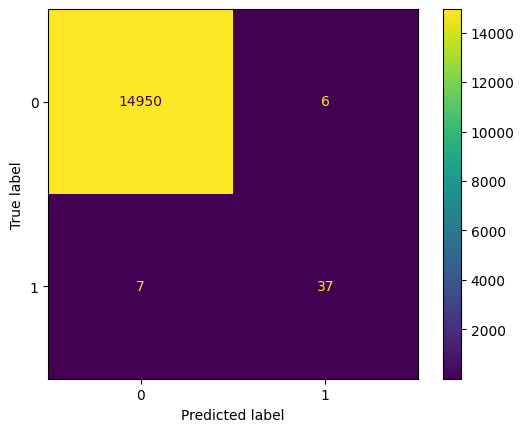

In [28]:
print("Stacking Classifier")
get_metrics_plot_confusion_matrix(clf_stacking, x_test, y_test, y_pred_stacking)


In [29]:
import xgboost # подключим библиотеку XGboost
from xgboost import XGBClassifier

In [30]:
estimators = [
    ('RandomForest', RandomForestClassifier(n_estimators=50, max_depth=5, max_features=2)),
    ('GradientBoosting', XGBClassifier()),
    ('DecisionTree', DecisionTreeClassifier(max_depth=3))
]

In [31]:
clf_stacking = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
clf_stacking.fit(x_train, y_train)
y_pred_stacking = clf_stacking.predict(x_test)

d:\_petrsu\data_analysis_in_python\007_classification_tabular_data\.venv\lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The XGBClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
d:\_petrsu\data_analysis_in_python\007_classification_tabular_data\.venv\lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The XGBClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base

AttributeError: 'super' object has no attribute '__sklearn_tags__'

In [ ]:
print("Stacking Classifier")
get_metrics_plot_confusion_matrix(clf_stacking, x_test, y_test, y_pred_stacking)
